# Stock Market Analysis of the Tech Industry during the Pandemic

We are trying to analyse the stock market data gathered using Yahoo! Finance API to figure out tech companies that did well during the Covid-19 Pandemic. 
1. Data Preperation
2. Feature Engineering
3. Data Visualisation/Understanding
4. KNN Clustering 

- All of the above except Visualisations will be done with PySpark so that our code is scalable over large data as well

Required Libraries

In [28]:
import numpy as np
import pprint
from pandas_datareader import data
from pyspark.ml.feature import VectorAssembler, StandardScaler, Normalizer

from pyspark.ml.clustering import KMeans, BisectingKMeans

from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import PCA as PCAml

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd


##### Companies Chosen
- We are chosing a subset of 50 companies from the Nasdaq index. The data is gathered using Pandas_datareader library that internally calls the Yahoo! Finance API for date ranges between 31st December 2019 to 31st December 2021.

In [29]:
companies_dict = {
'Amazon': 'AMZN',
'Apple': 'AAPL',
'Zoom Video Communications Inc.' : 'ZM',
'Intel Corp' : 'INTC' , 
'Tesla Inc' : 'TSLA' ,
'eBay Inc' : 'EBAY' ,
'Dollar Tree Inc' : 'DLTR' ,
'Activision Blizzard Inc' : 'ATVI' ,
'PepsiCo Inc.' : 'PEP' ,
'Costco Wholesale Corp' : 'COST' ,
'Pfizer Inc.' : 'PFE',
'JP Morgan Chase & Co.' : 'JPM' ,
'Bank of America Corporation' : 'BAC' ,
'Mastercard Incorporated' : 'MA' , 
'Manulife Financial Corporation' : 'MFC' ,
'Chevron Corporation' : 'CVX' , 
'NVIDIA Corporation' : 'NVDA' ,
'Walmart Inc.' : 'WMT' ,
'lululemon athletica inc.' : 'LULU' ,
'Walgreens Boots Alliance Inc.' : 'WBA' , 
'Nucor Corporation' : 'NUE' ,
'Devon Energy Corporation' : 'DVN' ,
'Motorola Solutions Inc.' : 'MSI' ,
'Chunghwa Telecom' : 'CHT' ,
'Barclays PLC' : 'BCS' ,
'Energy Transfer LP' : 'ET' ,
'Halliburton Company' : 'HAL' ,
'Fastenal Company' : 'FAST' ,
'Ross Stores, Inc.' : 'ROST' ,
'State Street Corporation' : 'STT' ,
'Otis Worldwide Corporation' : 'OTIS' ,
'Tyson Foods, Inc.' : 'TSN' ,
'PPG Industries, Inc.' : 'PGP' ,
'ONEOK, Inc.' : 'OKE' ,
'AMETEK, Inc.' : 'AME' ,
'Imperial Oil Limited' : 'IMO' ,
'Biogen Inc.' : 'BIIB' ,
'PACCAR Inc.' : 'PCAR' ,
'Agnico Eagle Mines Limited' : 'AEM' ,
'Telefonica SA' : 'TEF' ,
'Hormel Foods Corporation' : 'HRL' ,
'Rogers Communication, Inc.' : 'RCI' ,
'Albemarle Corporation' : 'ALB' ,
'Tractor Supply Company' : 'TSCO' , 
'United Rentals, Inc.' : 'URI' ,
'Ventas, Inc.' : 'VTR' ,
'Hewlett Packard Enterprise' : 'HPE' ,
'DocuSign, Inc.' : 'DOCU' ,
'Ulta Beauty, Inc.' : 'ULTA'
}


Initializing Spark

In [30]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Helper Functions

In [31]:
#Calculates the Movement for each stock
def calculate_movement(df, companies = list(companies_dict.values())):
    for i in range(len(companies)):
        coloumn_name = "Movement - " + companies[i]
        close = "('Close', '"+companies[i]+"')"
        open = "('Open', '"+companies[i]+"')"

        df = df.withColumn(coloumn_name, dff[close] - dff[open])
    
    return df

#Calcualtes the sum of Movements for each stock
def company_movement(df_rdd, companies = list(companies_dict.values())):
    n = len(companies)
    movement_dict = {}
    for i in range(n):
        movement_dict[companies[i]] = df_rdd.map(lambda x: (0,x[i])).reduceByKey(lambda x,y : x+y).collect()[0][1]

    return movement_dict

##### Data Preparation

In [32]:
companies = sorted(companies_dict.items(), key=lambda x: x[1])

#Data source to gather stock market information
data_source = 'yahoo'

# Define the start and end dates that we want to see
start_date = '2019-12-01'
end_date = '2021-01-01'

panel_data = data.DataReader(list(companies_dict.values()), data_source, start_date, end_date)
#Converting Pandas DataFrame to Spark DataFrame
dff = spark.createDataFrame(panel_data[['Open', 'Close', 'Adj Close', 'High']]).dropna()

DataFrame Schema
- Coloumn Names are combination of type of feature(Open or Close) + Stock Ticker

In [33]:
dff.printSchema()

root
 |-- ('Open', 'AMZN'): double (nullable = true)
 |-- ('Open', 'AAPL'): double (nullable = true)
 |-- ('Open', 'ZM'): double (nullable = true)
 |-- ('Open', 'INTC'): double (nullable = true)
 |-- ('Open', 'TSLA'): double (nullable = true)
 |-- ('Open', 'EBAY'): double (nullable = true)
 |-- ('Open', 'DLTR'): double (nullable = true)
 |-- ('Open', 'ATVI'): double (nullable = true)
 |-- ('Open', 'PEP'): double (nullable = true)
 |-- ('Open', 'COST'): double (nullable = true)
 |-- ('Open', 'PFE'): double (nullable = true)
 |-- ('Open', 'JPM'): double (nullable = true)
 |-- ('Open', 'BAC'): double (nullable = true)
 |-- ('Open', 'MA'): double (nullable = true)
 |-- ('Open', 'MFC'): double (nullable = true)
 |-- ('Open', 'CVX'): double (nullable = true)
 |-- ('Open', 'NVDA'): double (nullable = true)
 |-- ('Open', 'WMT'): double (nullable = true)
 |-- ('Open', 'LULU'): double (nullable = true)
 |-- ('Open', 'WBA'): double (nullable = true)
 |-- ('Open', 'NUE'): double (nullable = true)


- Movement in Stock Prices
  - ‘movement’ is defined as difference of opening and closing prices of a particular day. Positive movement suggests to go long on stock(buy) and negative movement suggests to short the stock(sell).

In [34]:
df_movements = calculate_movement(dff)
#Extracting only the movements coloumn for each ticker
df_move_ = df_movements.select(df_movements.columns[-1*len(companies_dict.values()):]).rdd

In [35]:
#Showing the movement for first 5 companies for first 20 days
df_move_.toDF().select(df_move_.toDF().columns[:5]).show()

+-----------------+-------------------+-------------------+--------------------+-------------------+
|  Movement - AMZN|    Movement - AAPL|      Movement - ZM|     Movement - INTC|    Movement - TSLA|
+-----------------+-------------------+-------------------+--------------------+-------------------+
| 20.9300537109375|-0.6525001525878906| 0.8199996948242188| -1.9000015258789062| 10.587997436523438|
|-80.2200927734375| -4.484996795654297| 1.5500030517578125| -0.6799964904785156| -2.134002685546875|
| 75.0799560546875|-0.9275016784667969| 17.563003540039062|  3.5600013732910156|   0.13800048828125|
|-11.4000244140625| 2.6300010681152344| -18.82000732421875| -0.7399978637695312|  5.540000915527344|
|-34.8499755859375|-1.3074989318847656|   -1.9949951171875|  -1.220001220703125|-1.2000045776367188|
|  53.489990234375|  2.979999542236328| 0.6399993896484375|   3.799999237060547|-3.8459930419921875|
| -30.760009765625|-1.2524986267089844|                6.0| -1.0499992370605469| 1.87200164

In [36]:
#Calculating the sum of movements for the given period of pandemic
cmd = company_movement(df_move_)

In [37]:
#Using Pretty Print to print the dictionaries
pprint.pprint(cmd)

{'AAPL': 1.769927978515625,
 'AEM': 4.190097808837891,
 'ALB': 52.04994201660156,
 'AME': 7.940032958984375,
 'AMZN': -188.4609375,
 'ATVI': -0.009983062744140625,
 'BAC': -3.579986572265625,
 'BCS': -0.7000002861022949,
 'BIIB': -28.530029296875,
 'CHT': -2.759979248046875,
 'COST': -25.240081787109375,
 'CVX': -9.889995574951172,
 'DLTR': -5.909996032714844,
 'DOCU': -16.668006896972656,
 'DVN': 0.6900067329406738,
 'EBAY': 2.9600276947021484,
 'ET': -4.42000150680542,
 'FAST': 6.0700225830078125,
 'HAL': 5.729994297027588,
 'HPE': 0.6349925994873047,
 'HRL': -5.580013275146484,
 'IMO': -4.6399970054626465,
 'INTC': 1.6399803161621094,
 'JPM': -25.620010375976562,
 'LULU': 25.650009155273438,
 'MA': -51.40971374511719,
 'MFC': 1.4999942779541016,
 'MSI': -26.499954223632812,
 'NUE': 3.9899978637695312,
 'NVDA': -7.292442321777344,
 'OKE': 3.109996795654297,
 'OTIS': 27.931072235107422,
 'PCAR': 10.359973907470703,
 'PEP': -6.209991455078125,
 'PFE': -19.621536254882812,
 'PGP': 2.190

## Visualisations to Understand Data

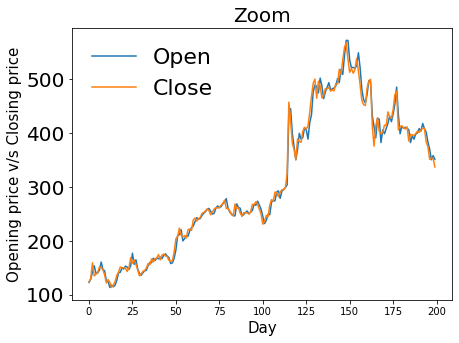

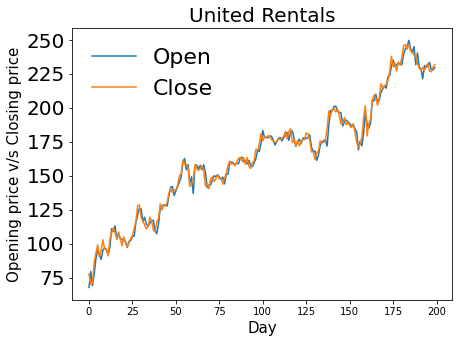

In [38]:
#Create Opening Price v/s Closing Price for Zoom and United Rentals

plt.figure(figsize = (15,5)) 
plt.subplot(1,2,1) 
plt.title("Zoom",fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)
plt.xlabel("Day",fontsize = 15)
plt.ylabel("Opening price v/s Closing price",fontsize = 15)
plt.plot(dff.select("('Open', 'ZM')").collect(), label = "Open")
plt.plot(dff.select("('Close', 'ZM')").collect(), label = "Close")
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})

plt.figure(figsize = (15,5)) 
plt.subplot(1,2,1) 
plt.title("United Rentals",fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)
plt.xlabel("Day",fontsize = 15)
plt.ylabel("Opening price v/s Closing price",fontsize = 15)
plt.plot(dff.select("('Open', 'URI')").collect(), label = "Open")
plt.plot(dff.select("('Close', 'URI')").collect(), label = "Close")
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})

plt.show()


- Stocks with postive movement are advisable to go long, whereas stocks with negative movement are generally advised to short(sell)

In [39]:
#Transposing DataFrame to obtain the Vector of recorded Movements for each Company
move_df = spark.createDataFrame(df_move_.toDF().toPandas().sort_index().transpose())
#move_df.show(50)

### Normalization
- Need for Normalization
  - Stock prices of different companies have different scales hence changing the scale for respective movements. Normalizaton will change the numberic values of movements to a common scale without distorting the difference in the range of values

- We will be using Normalizer provided by the pyspark.ml.features library

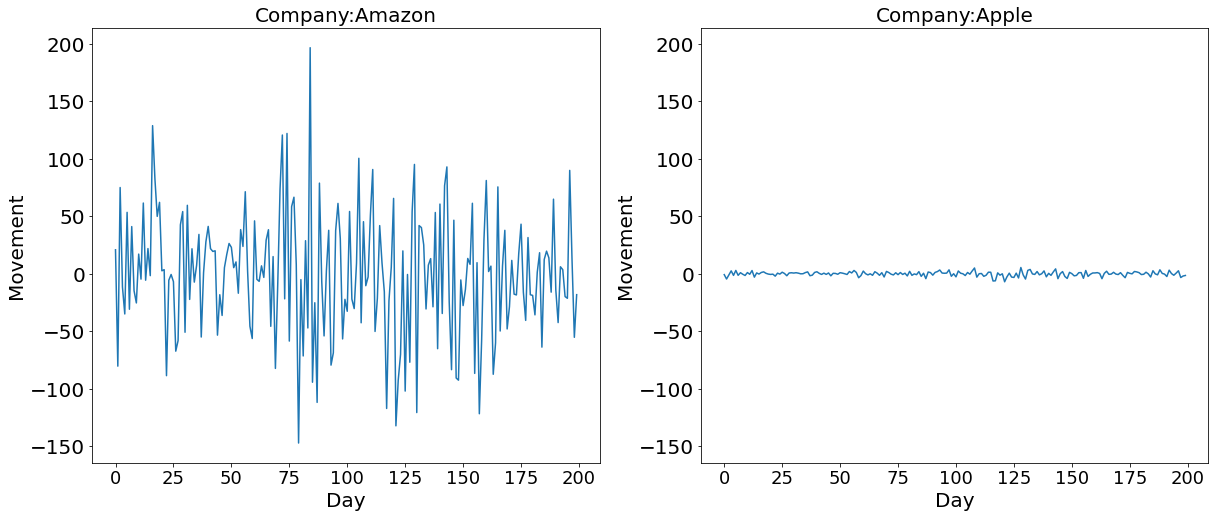

In [40]:
plt.figure(figsize = (20,8)) 
ax1 = plt.subplot(1,2,1)
plt.title('Company:Amazon',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Day',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(df_move_.toDF().select('Movement - AMZN').collect()) 
plt.subplot(1,2,2,sharey = ax1)
plt.title('Company:Apple',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Day',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(df_move_.toDF().select('Movement - AAPL').collect())

- Stock prices of Amazon and Apple have different scales. Thus x units of change in stock price of Amazon is not the same as x units of change in stock price of Apple. Some companies are worth a lot more than other companies. Hence the data has to be normalized.

In [41]:
#All movements over the period will be stored in a new column 'vector_features'
assemble = VectorAssembler(inputCols=move_df.columns, outputCol='vector_features')
assembled_data = assemble.transform(move_df)

In [42]:
#All scaled movements over the period will be stored in a new column 'scaled'
normalizer = Normalizer(inputCol="vector_features", outputCol="scaled")
df1 = normalizer.transform(assembled_data)

- Data after Normalization

C:\Users\vmarh\anaconda3\envs\bigdata-lab\lib\site-packages\pyspark\sql\pandas\conversion.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
C:\Users\vmarh\anaconda3\envs\bigdata-lab\lib\site-packages\pyspark\sql\pandas\conversion.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


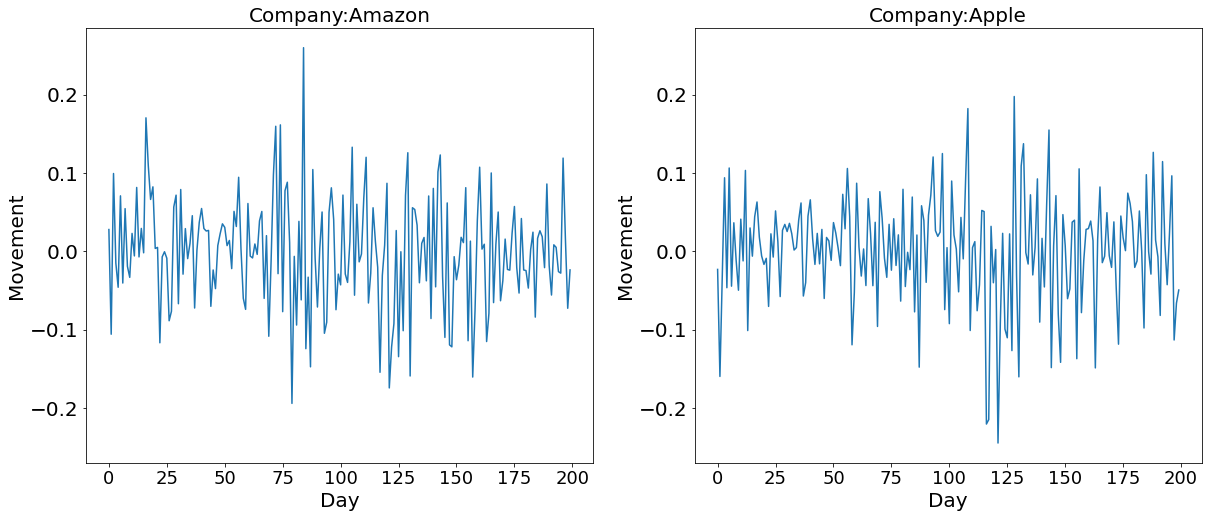

In [43]:
plt.figure(figsize = (20,8)) 
ax1 = plt.subplot(1,2,1)
plt.title('Company:Amazon',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Day',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(df1.toPandas()['scaled'][0]) 
plt.subplot(1,2,2,sharey = ax1)
plt.title('Company:Apple',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Day',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(df1.toPandas()['scaled'][1])

# Model 1 - Kmeans Clustering
- k-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters.
- KMeans is implemented as an Estimator and generates a KMeansModel as the base model.

##### Trying to find the right number of clusters using the silhouette Elbow method

In [44]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='scaled', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='scaled', k=K)

    KMeans_fit=KMeans_.fit(df1)

    KMeans_transform=KMeans_fit.transform(df1) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0.5, 1.0, 'Elbow Method - KMeans')

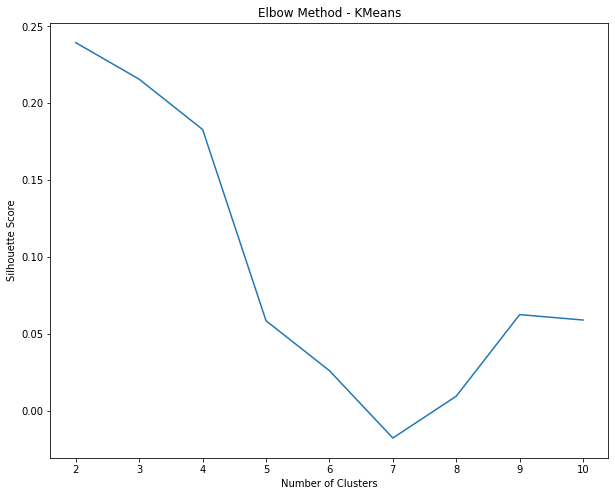

In [45]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title("Elbow Method - KMeans")

- Since we get a Local Maxima at k = 4, We will look for 4 clusters

In [46]:
KMeans_=KMeans(featuresCol='scaled', k=4) 
KMeans_Model=KMeans_.fit(df1)
KMeans_Assignments=KMeans_Model.transform(df1)

### Principal Component Analysis
- To visualise the high dimensional data (300+ features, for each day in period) we need to use PCA to reduce the data dimensionality to 2 

In [47]:
pca = PCAml(k=2, inputCol="scaled", outputCol="pca")
pca_model = pca.fit(df1)
pca_transformed = pca_model.transform(df1)


x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())
#x_pca


In [48]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
#cluster_assignment

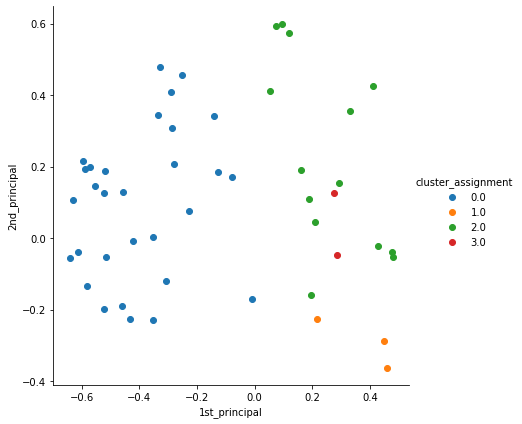

In [49]:
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [50]:
cluster_df = pd.DataFrame({"Cluster_assignment" : np.squeeze(cluster_assignment), "Company" : list(companies_dict.keys())})
#cluster_assignment[0], companies_dict.keys()
cluster_df

,Cluster_assignment,Company
0,2,Amazon
1,2,Apple
2,1,Zoom Video Communications Inc.
3,2,Intel Corp
4,1,Tesla Inc
5,3,eBay Inc
6,0,Dollar Tree Inc
7,2,Activision Blizzard Inc
8,2,PepsiCo Inc.
9,2,Costco Wholesale Corp


# Model 1 - Bisecting KMeans Clustering
- Bisecting k-means is a kind of hierarchical clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.
- Bisecting K-means can often be much faster than regular K-means, but it will generally produce a different clustering.

- BisectingKMeans is implemented as an Estimator and generates a BisectingKMeansModel as the base model.

In [51]:

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='scaled', \
metricName='silhouette')
for K in range(2,11):

    BKMeans_=BisectingKMeans(featuresCol='scaled', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(df1)

    BKMeans_transform=BKMeans_fit.transform(df1) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0.5, 1.0, 'Elbow Method - Bisecting KMeans')

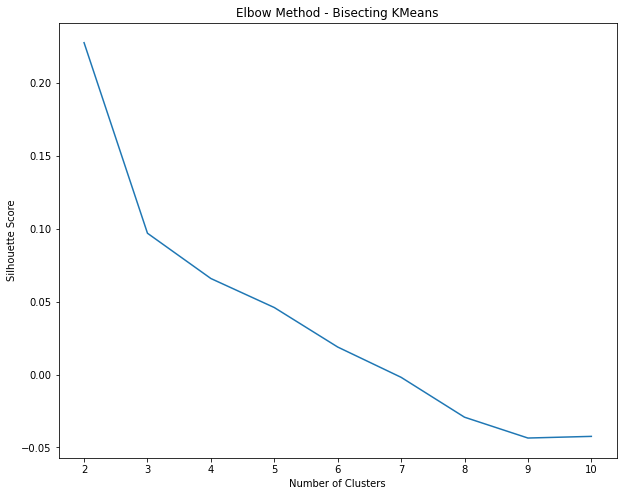

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title("Elbow Method - Bisecting KMeans")


- Since we get a Local Maxima at k = 3, We will look for 3 clusters

In [53]:
BKMeans_=BisectingKMeans(featuresCol='scaled', k=3) 
BKMeans_Model=BKMeans_.fit(df1)
BKMeans_transform=BKMeans_Model.transform(df1)

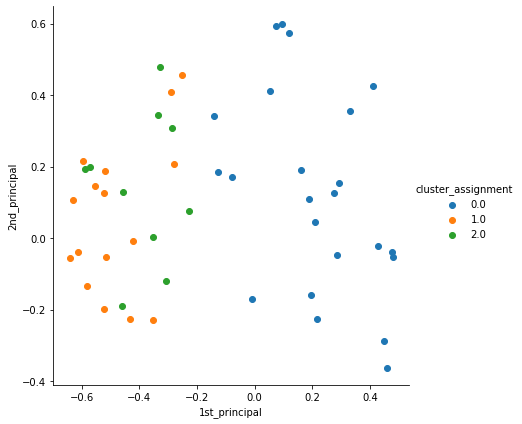

In [54]:
pca = PCAml(k=2, inputCol="scaled", outputCol="pca")
pca_model = pca.fit(df1)
pca_transformed = pca_model.transform(df1)

X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)

cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()